In [186]:
"""
This program is an example of Transfer Learning using PyTorch AlexNet
It classifies flower images from the following dataset into five classes
http://download.tensorflow.org/example_images/flower_photos.tgz
Executed on Google Colab with GPU, with Python 3.7.12 and PyTorch 1.10.0 
"""

'\nThis program is an example of Transfer Learning using PyTorch AlexNet\nIt classifies flower images from the following dataset into five classes\nhttp://download.tensorflow.org/example_images/flower_photos.tgz\nExecuted on Google Colab with GPU, with Python 3.7.12 and PyTorch 1.10.0 \n'

In [284]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.model_selection import train_test_split
import gc

In [285]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [286]:
# Initialize variables 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 164
IMAGE_SHAPE = (224, 224)
data_dir = "/content/gdrive/My Drive/Data/flower_photos"
num_classes = 5


In [287]:
# Load dataset and pre-process them
roses = glob.glob(data_dir+'/roses/**/*.jpg', recursive=True)
daisy = glob.glob(data_dir+'/daisy/**/*.jpg', recursive=True)
tulips = glob.glob(data_dir+'/tulips/**/*.jpg', recursive=True)
dandelion = glob.glob(data_dir+'/dandelion/**/*.jpg', recursive=True)
sunflowers = glob.glob(data_dir+'/sunflowers/**/*.jpg', recursive=True)

In [288]:
img_labels = ["roses", "daisy", "tulips", "dandelion", "sunflowers"]

X, y = [], []
for label, name in enumerate(img_labels):
    exec("img_list = %s" % (name))
    for img in img_list:
        img = cv2.imread(img)
        resized_img = cv2.resize(img, IMAGE_SHAPE) 
        X.append(resized_img)
        y.append(label)
    
X = np.array(X, dtype=np.float32)
y = np.array(y)


In [289]:
# Normalize image pixel values 0 to 1
X = X/255

In [290]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)
# Split again into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111111)


In [291]:
# Convert dataset from numpy to pytorch tensor
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
X_val = torch.from_numpy(X_val)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
y_val = torch.from_numpy(y_val)

X_train = X_train.to(device)
X_test = X_test.to(device)
X_val = X_val.to(device)
y_train = y_train.to(device, dtype=torch.long)
y_test = y_test.to(device, dtype=torch.long)
y_val = y_val.to(device, dtype=torch.long)

X_train = torch.transpose(X_train, 1, 3)
X_test = torch.transpose(X_test, 1, 3)
X_val = torch.transpose(X_val, 1, 3)

In [292]:
# Create DataLoaders
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
val_data = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [293]:
# Load pretrained AlexNet and modify last layer
alexnet = models.alexnet(pretrained=True)

# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

# Add final layer as per num_classes
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))

alexnet = alexnet.to(device)
# print alexnet
print(alexnet)

# Loss function and optimizer
criterion  = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters())

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [294]:
# Define model training function
def train(model, criterion, optimizer, epochs):  
    history = []
    train_size = len(y_train)
    val_size = len(y_val)
    for epoch in range(epochs):
        # Training
        total_train_loss = 0
        total_train_correct = 0
        for images, labels in train_loader: 
            # To fix a memory allocation issue
            gc.collect()
        
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
        
            # Compute loss
            loss = criterion(outputs, labels)
            total_train_loss += loss
            
            # Calculate total correct classification
            y_predicted = torch.argmax(outputs, axis=1)
            total_train_correct += ((y_predicted == labels).sum())
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
        # Compute accuracy
        train_acc = 100*((total_train_correct/train_size).item())
        # Compute average loss
        train_loss = total_train_loss/train_size
        
        # Validation
        with torch.no_grad():
            total_val_loss = 0
            total_val_correct = 0
            for images, labels in val_loader:
                # To fix a memory allocation issue
                gc.collect()
                
                # Predict
                outputs = model(images)
        
                # Compute loss
                loss = criterion(outputs, labels)
                total_val_loss += loss
            
                # Calculate total correct classification
                y_predicted = torch.argmax(outputs, axis=1)
                total_val_correct += ((y_predicted == labels).sum())
                
            # Compute accuracy
            val_acc = 100*((total_val_correct/val_size).item())
            # Compute average loss
            val_loss = total_val_loss/val_size
        
        # For each epoch update history
        history.append([train_loss, val_loss, train_acc, val_acc])
        if epoch % 1 == 0:
            print(f"Epoch {epoch+1}: Training Accuracy = {train_acc:.3f}%  Training Loss = {train_loss:.5f}")
            print(f"\t\t Validation Accuracy = {val_acc:.3f}%  Validation Loss = {val_loss:.5f}")

    return model, history


In [295]:
# Start training
num_epochs = 10
model, history = train(alexnet, criterion, optimizer, num_epochs)   

Epoch 1: Training Accuracy = 63.076%  Training Loss = 0.00589
		 Validation Accuracy = 74.255%  Validation Loss = 0.00513
Epoch 2: Training Accuracy = 78.252%  Training Loss = 0.00372
		 Validation Accuracy = 77.236%  Validation Loss = 0.00475
Epoch 3: Training Accuracy = 80.522%  Training Loss = 0.00326
		 Validation Accuracy = 81.030%  Validation Loss = 0.00454
Epoch 4: Training Accuracy = 82.927%  Training Loss = 0.00297
		 Validation Accuracy = 80.217%  Validation Loss = 0.00471
Epoch 5: Training Accuracy = 83.232%  Training Loss = 0.00277
		 Validation Accuracy = 78.049%  Validation Loss = 0.00459
Epoch 6: Training Accuracy = 83.570%  Training Loss = 0.00260
		 Validation Accuracy = 81.301%  Validation Loss = 0.00447
Epoch 7: Training Accuracy = 84.587%  Training Loss = 0.00256
		 Validation Accuracy = 82.385%  Validation Loss = 0.00428
Epoch 8: Training Accuracy = 85.603%  Training Loss = 0.00242
		 Validation Accuracy = 81.030%  Validation Loss = 0.00446
Epoch 9: Training Accura

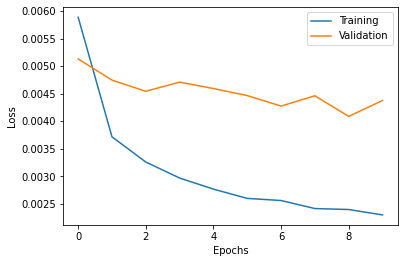

In [296]:
# Plot training and validation loss
new_history = torch.tensor(history, device = 'cpu')
plt.plot(new_history[:, 0:2])
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [297]:
# Finally predict on the test images
outputs = model(X_test)
y_predicted = torch.argmax(outputs, axis=1)
acc = 100 * ((((y_predicted == y_test).sum())/len(y_test)).item())

print(f"\nThe final model accuracy on the test data = {acc:.3f}%")



The final model accuracy on the test data = 80.270%
